In [4]:
import pandas as pd

# Load raw combined dataset
df = pd.read_csv("data/processed/combined_news_type_dataset.csv")
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["text"] = df["text"].apply(clean_text)

# Map raw subjects to generalized types
subject_map = {
    "politicsNews": "politics",
    "politics": "politics",
    "Government News": "politics",
    "left-news": "politics",
    "US_News": "national",
    "Middle-east": "world",
    "worldnews": "world",
    "News": "general",
    "entertainment": "entertainment"
}
df["subject_mapped"] = df["subject"].map(subject_map)

# Drop old subject column
df.drop(columns=["subject"], inplace=True)

# Check final class distribution
print(df["subject_mapped"].value_counts())


subject_mapped
politics         24142
world            10923
entertainment     9879
general           9050
national           783
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["subject_mapped"]

# 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# One-hot encode for DL
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Save number of classes
num_classes = y_train_cat.shape[1]


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad
max_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional

# BiLSTM
def build_bilstm():
    model = Sequential([
        Embedding(10000, 128, input_length=max_len),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# CNN
def build_cnn():
    model = Sequential([
        Embedding(10000, 128, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# GRU
def build_gru():
    model = Sequential([
        Embedding(10000, 128, input_length=max_len),
        GRU(64),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [9]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def train_and_evaluate(model, name):
    print(f"\n Training {name}...")
    model.fit(X_train_pad, y_train_cat, validation_split=0.2, epochs=5, batch_size=64, verbose=2)

    y_pred = model.predict(X_test_pad)
    y_pred_class = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test_enc, y_pred_class)
    print(f"\n Accuracy: {acc:.4f}")
    print(f"\n Classification Report for {name}:")
    print(classification_report(y_test_enc, y_pred_class, target_names=label_encoder.classes_))
    return model


In [10]:
bilstm_model = train_and_evaluate(build_bilstm(), "BiLSTM")
cnn_model = train_and_evaluate(build_cnn(), "CNN")
gru_model = train_and_evaluate(build_gru(), "GRU")


C:\Users\admin\fakenews_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



🔁 Training BiLSTM...
Epoch 1/5
480/480 - 256s - 533ms/step - accuracy: 0.8428 - loss: 0.4657 - val_accuracy: 0.9085 - val_loss: 0.2803
Epoch 2/5
480/480 - 175s - 365ms/step - accuracy: 0.9406 - loss: 0.1872 - val_accuracy: 0.9272 - val_loss: 0.1947
Epoch 3/5
480/480 - 202s - 421ms/step - accuracy: 0.9158 - loss: 0.2385 - val_accuracy: 0.9147 - val_loss: 0.3227
Epoch 4/5
480/480 - 177s - 368ms/step - accuracy: 0.9063 - loss: 0.2926 - val_accuracy: 0.8575 - val_loss: 0.3775
Epoch 5/5
480/480 - 178s - 372ms/step - accuracy: 0.9218 - loss: 0.2337 - val_accuracy: 0.9224 - val_loss: 0.2285
514/514 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step

✅ Accuracy: 0.9255

📊 Classification Report for BiLSTM:
               precision    recall  f1-score   support

entertainment       0.99      0.94      0.96      2964
      general       1.00      0.99      0.99      2715
     national       0.42      0.22      0.29       235
     politics       0.94      0.93      0.94      7243
        world       0.81      0.

C:\Users\admin\fakenews_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


480/480 - 68s - 141ms/step - accuracy: 0.8577 - loss: 0.3933 - val_accuracy: 0.9484 - val_loss: 0.1374
Epoch 2/5
480/480 - 66s - 138ms/step - accuracy: 0.9546 - loss: 0.1280 - val_accuracy: 0.9531 - val_loss: 0.1209
Epoch 3/5
480/480 - 65s - 136ms/step - accuracy: 0.9679 - loss: 0.0806 - val_accuracy: 0.9512 - val_loss: 0.1212
Epoch 4/5
480/480 - 65s - 136ms/step - accuracy: 0.9758 - loss: 0.0548 - val_accuracy: 0.9476 - val_loss: 0.1408
Epoch 5/5
480/480 - 65s - 136ms/step - accuracy: 0.9783 - loss: 0.0470 - val_accuracy: 0.9488 - val_loss: 0.1478
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step

✅ Accuracy: 0.9447

📊 Classification Report for CNN:
               precision    recall  f1-score   support

entertainment       0.99      0.98      0.98      2964
      general       0.99      0.99      0.99      2715
     national       0.37      0.39      0.38       235
     politics       0.96      0.96      0.96      7243
        world       0.88      0.89      0.88      3277

     accuracy    

C:\Users\admin\fakenews_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


480/480 - 99s - 206ms/step - accuracy: 0.7098 - loss: 0.7150 - val_accuracy: 0.9129 - val_loss: 0.2531
Epoch 2/5
480/480 - 91s - 189ms/step - accuracy: 0.9358 - loss: 0.1953 - val_accuracy: 0.9429 - val_loss: 0.1466
Epoch 3/5
480/480 - 90s - 187ms/step - accuracy: 0.9615 - loss: 0.1065 - val_accuracy: 0.9442 - val_loss: 0.1525
Epoch 4/5
480/480 - 90s - 187ms/step - accuracy: 0.9699 - loss: 0.0801 - val_accuracy: 0.9475 - val_loss: 0.1671
Epoch 5/5
480/480 - 89s - 186ms/step - accuracy: 0.9723 - loss: 0.0664 - val_accuracy: 0.9454 - val_loss: 0.1775
514/514 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step

✅ Accuracy: 0.9423

📊 Classification Report for GRU:
               precision    recall  f1-score   support

entertainment       0.99      0.97      0.98      2964
      general       1.00      0.99      0.99      2715
     national       0.00      0.00      0.00       235
     politics       0.95      0.95      0.95      7243
        world       0.84      0.93      0.88      3277

     accuracy   

C:\Users\admin\fakenews_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\fakenews_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\fakenews_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [12]:
import numpy as np
from sklearn.metrics import f1_score

# Predict probabilities
y_pred_bilstm = bilstm_model.predict(X_test_pad)
y_pred_cnn    = cnn_model.predict(X_test_pad)
y_pred_gru    = gru_model.predict(X_test_pad)

# Convert probabilities to class predictions
y_pred_bilstm_cls = np.argmax(y_pred_bilstm, axis=1)
y_pred_cnn_cls    = np.argmax(y_pred_cnn, axis=1)
y_pred_gru_cls    = np.argmax(y_pred_gru, axis=1)


514/514 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
514/514 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step


In [13]:
f1_bilstm = f1_score(y_test_enc, y_pred_bilstm_cls, average='weighted')
f1_cnn    = f1_score(y_test_enc, y_pred_cnn_cls, average='weighted')
f1_gru    = f1_score(y_test_enc, y_pred_gru_cls, average='weighted')

print(f"BiLSTM F1-score: {f1_bilstm:.4f}")
print(f"CNN    F1-score: {f1_cnn:.4f}")
print(f"GRU    F1-score: {f1_gru:.4f}")


BiLSTM F1-score: 0.9244
CNN    F1-score: 0.9451
GRU    F1-score: 0.9364


In [14]:
best_model_name = max(
    [('BiLSTM', f1_bilstm), ('CNN', f1_cnn), ('GRU', f1_gru)],
    key=lambda x: x[1]
)

print(f"\nBest DL Model: {best_model_name[0]} with F1-score: {best_model_name[1]:.4f}")



🔍 Best DL Model: CNN with F1-score: 0.9451


<Figure size 1000x600 with 0 Axes>

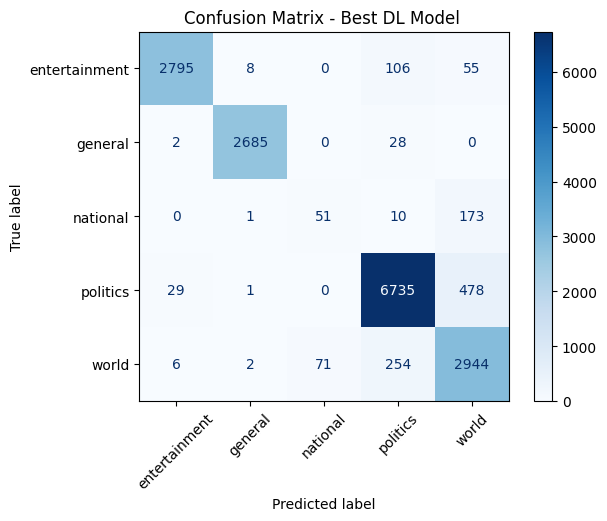

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot
plt.figure(figsize=(10, 6))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Best DL Model ")
plt.show()


In [21]:
cnn_model.save("models/cnn_model.h5")
import joblib

joblib.dump(tokenizer, "models/cnn_tokenizer.pkl")



['models/cnn_tokenizer.pkl']